First I directly use the dataset from Udacity,  then I found there are only three label: car,truck,....But have no sky, no road,no others...  
Then I changed the dataset.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import csv
import numpy as np
import cv2
import matplotlib.image as mpimg

import glob

#父目录中的.py文件
veh_images = glob.glob('vehicles/*/*.png')
print(len(veh_images))
not_veh_images = glob.glob('non-vehicles/*/*.png')
print(len(not_veh_images))


8792
8968


The vechiles and not_vechiles data set is nearly the same
The other problem I found later is that there are too many duplicate image, so I only use 10% of the image data set 

In [122]:
import random
car_set = random.sample(veh_images,int(len(veh_images)/6))
not_car_set = random.sample(not_veh_images,int(len(veh_images)/6))

print(len(car_set),len(not_car_set))


1465 1465


Display some images

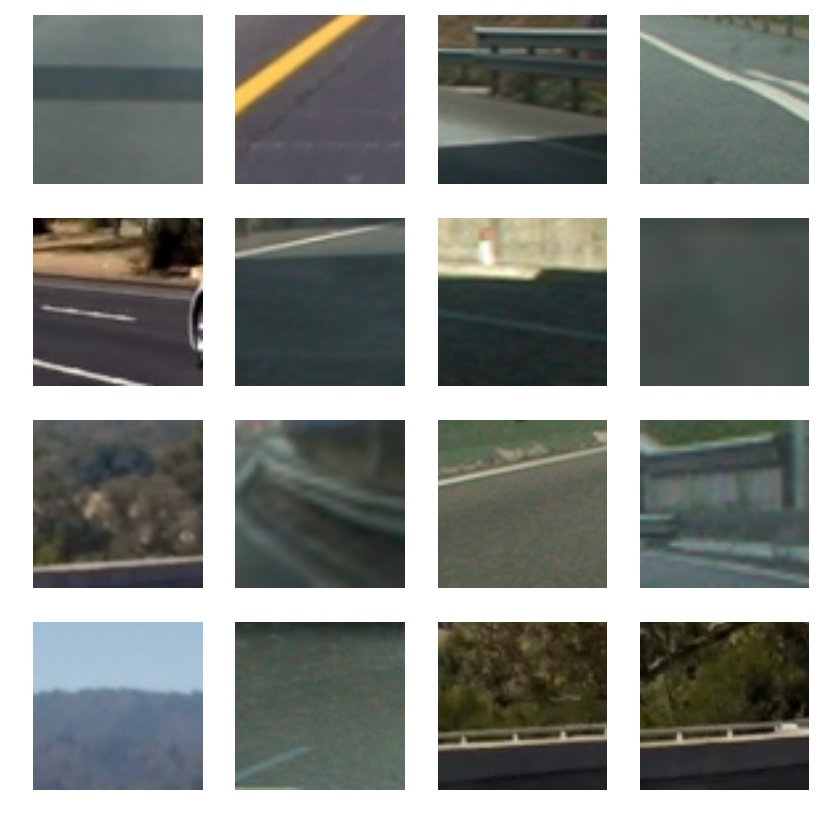

In [123]:
figure = plt.figure(figsize=(10,10))
factors = [4,4]
i = random.randint(0,900)
    
for ind in range(16):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    val =  mpimg.imread(not_car_set[i+ind]) 
    plt.axis("off")
    plt.imshow(val, cmap='gray')

    

Now I have the car_set and not_car_set, both are 1099  
Next I will build the training set and labels set.   
there are 3 function , one is bin_spatial, the second is color hist, the third is get_hog_features, which will be trid in feature extra

In [124]:
from skimage.feature import hog

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector    
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print('def func')

def func


Feature_extra, which combine the three above together

In [125]:
# Have this function call bin_spatial() and color_hist()
def extract_features(rows, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    i=0
    # Iterate through the list of images
    for row in rows:
        # Read in each one by one,then crop the image to the car
        
        image = mpimg.imread(row)       
        feature_image = cv2.resize(image, (64, 64)) 
        bin_features = bin_spatial(feature_image)
        color_features = color_hist(feature_image)
        
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        hog_features = []
        if hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list                                    
        features.append(np.concatenate((bin_features,color_features,hog_features)))        
        #features.append(hog_features)

    # Return list of feature vectors
    return features

print('extra_function')


extra_function


we use extract_features build our train_set

In [126]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.metrics import accuracy_score

print('extra_features begin...')
sample=1000
car_features = extract_features(car_set, hog_channel='ALL')
not_car_features= extract_features(not_car_set, hog_channel='ALL')
print('extra_features end...')

 

extra_features begin...
extra_features end...


In [127]:
#train the set
def train_clf(car_features,not_car_features):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, not_car_features)).astype(np.float64)
        
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
        print('y',y.shape)

        scaled_X, y = shuffle(scaled_X, y)
                                
        # Split to train and test
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)
        
        parameters = {'kernel':('linear','rbf'), 'C':[0.1,1,5, 10]}

        # TODO：initial classifier
        clf = svm.SVC()
        # Train the SVC
        grid_obj = GridSearchCV(clf,parameters)

        # TODO: Fit the grid search object to the training data and find the optimal parameters
        grid_obj = grid_obj.fit(X_train,y_train)

        # Get the estimator
        clf = grid_obj.best_estimator_    
        
        #clf = LinearSVC()
        #clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        print("Tuned model has a testing accuracy_score score of {:.4f}.".format(accuracy_score(y_test, y_pred)))
        return clf,X_scaler

clf,X_scaler = train_clf(car_features,not_car_features)  

y (2930,)
Tuned model has a testing accuracy_score score of 0.9932.


In [53]:
def validate_y(X_scale,clf,not_car_set):
    valid_not_car= extract_features(not_car_set[1000:1090], hog_channel='ALL')
    valid_car= extract_features(car_set[1000:1090], hog_channel='ALL')
    V_not = np.array(valid_not_car).astype(np.float64)
    V_car = np.array(valid_car).astype(np.float64)
    # Apply the scaler to X
    scaled_not = X_scaler.transform(V_not)
    scaled_car = X_scaler.transform(V_car)
    y = np.zeros(90)
    y_ped = clf.predict(scaled_not)    
    y_car = np.ones(90)
    y_ped_car = clf.predict(scaled_car)
    print('not car image accuracy',accuracy_score(y_ped,y))
    print('car image accuracy',accuracy_score(y_ped_car,y_car))

validate_y(X_scaler, clf,not_car_set)    

not car image accuracy 1.0
car image accuracy 0.955555555556


Search and classfiy

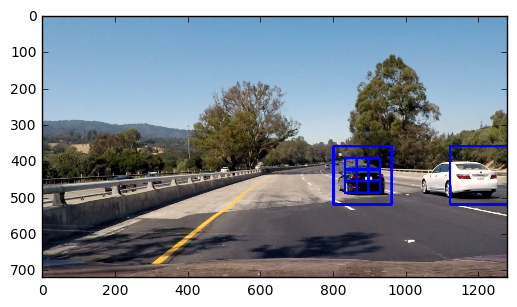

In [130]:
# Have this function call bin_spatial() and color_hist()
def single_img_features(feature_image, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
   
    bin_features = bin_spatial(feature_image)
    color_features = color_hist(feature_image)


    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    if hog_channel == 'ALL':            
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
          
    # Return list of feature vectors
    return  np.concatenate((bin_features,color_features,hog_features))
    


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, hog_channel='ALL'):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    img_features=[]
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        #img_features.append(features)
    #8) Return windows for positive detections
    return on_windows
    
    
def draw_vechile(image,debug=False):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

   
    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows=[]
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+150], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        xy_window=(160, 160), xy_overlap=(0.5, 0.5))
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        xy_window=(256, 256), xy_overlap=(0.5, 0.5))

    windows=windows1+windows2+windows3+windows4

    hot_windows = search_windows(image, windows, clf, X_scaler)   
    #img_features = X_scaler.transform(np.array(img_features).astype(np.float64))
    if debug==True:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img, hot_windows
    return hot_windows


window_img,hot_windows = draw_vechile(mpimg.imread('test_images/test4.jpg'),debug=True)
plt.imshow(window_img)
#print(clf.predict(img_features))

then use False Positives

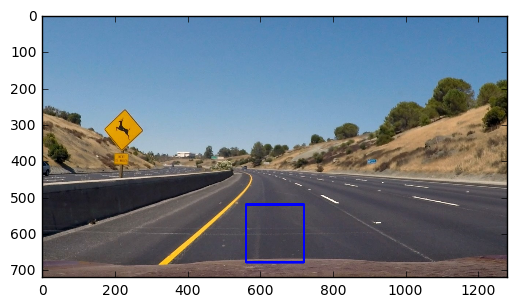

In [117]:
from scipy.ndimage.measurements import label



def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_map(image,debug=False):
    hot_windows = draw_vechile(image)
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if debug==True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    return draw_img

#draw_img = heat_map(mpimg.imread('test_images/test1.jpg'))
plt.imshow(heat_map(mpimg.imread('test_images/test2.jpg')))


In [116]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'out_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(heat_map) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


100%|█████████▉| 1260/1261 [1:00:20<00:02,  2.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_video.mp4 

CPU times: user 1h 12s, sys: 55.1 s, total: 1h 1min 7s
Wall time: 1h 22s
